<a href="https://colab.research.google.com/github/tamburins/ESAA_2023/blob/main/ESAA_3_27_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

# Titanic Top 4% with ensemble modeling

# 1. Introduction
part of feature analysis, feature engineering, modeling


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Look and check data
## 2.1 Load data

In [69]:
train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/OB/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [70]:
def detect_outliers(df, n,features):
  ''''
  Takes a dataframe df of features and returns a list of the indices
  corresponding to the observations containg more than n oulier according to the Tukey method
  '''
  outlier_indices = []
  # iterate over features(columns)
  for col in features:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1

    outlier_step = 1.5*IQR

    #determine a list of indices of ouliers for feature col
    outlier_list_col = df[(df[col]<Q1 - outlier_step)|(df[col] > Q3 + outlier_step)].index
    #append the found outlier indices for col to the list of outlier indices
    outlier_indices.extend(outlier_list_col)

    #select observations contatinig more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v>n)

    return multiple_outliers

# detect outliers from age, sibsp, parch, and fare
Outliers_to_drop = detect_outliers(train,2,['Age', 'SibSp','Parch', 'Fare'])


이상치는 예측에 큰 영향을 줄 수 있기 때문에 이를 관리할 필요가 있다.

이상치 탐지를 위해 사분위수 범위를 정의하는 Tukey 메스우드를 자주 사용한다. 이상치는 IQR에 outlier step만큼에서 벗어나는 특징을 가진 행이라 할 수 있다.

연속변수에서의 이상치를 탐지하기로 했다. 최소 두개의 이상치 변수를 갖는 행을 고려했다.

In [71]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


10개의 이상치를 찾았고, 28,89,342번째의 승객이 높은 티켓값을 갖는다
7명의 다른 사람들은 SibSP에 대해 너무 높은 값을 갖는다.

In [72]:
#drop them
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 joining train and test set

In [73]:
# join train and test datasets in order to obatin the sane number of eature during categorical conversion
train_len = len(train)
dataset= pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

범주형 변수를 다루는 동안에 있어서 같은 숫자의 피처를 획득하기 위해 train과 test를 결합하였다.

## 2.4 check for null and missing  values

In [74]:
#fill empy and nanas values with nan
dataset = dataset.fillna(np.nan)
#check for null values
dataset.isnull().sum()


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Age와 Cabin 피처는 결측치에서 중요한 부분이다.

생존한 결측치는 테스트데이터셋과 상응한다.(이는 생존 컬럼이 테스트셋에 존재하지 않고 트레인과 테스트가 합쳐질 때 nan값이 대체되었기 때문이다)

In [75]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [76]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [78]:
#summarize data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 3. Features analysis
## 3.1 Numerical values

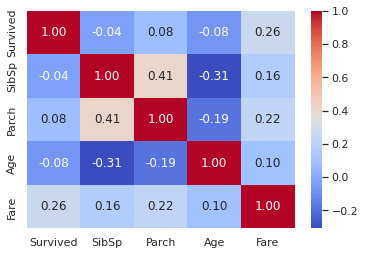

In [79]:
#연속형 변수와 target 사이 correlation matrix 
g=sns.heatmap(train[['Survived', 'SibSp','Parch','Age','Fare']].corr(), annot=True, fmt=".2f", cmap='coolwarm')

Fare feature만 상당한 상관이 있어보인다

다른 피처가 쓸모없다는게 아니라 subpopulation이 survival과 상관이 있을수도 있다는 것이다. 이것을 결정하기 위해서는 좀 더 탐색해볼 필요가 있다.

### SibSP

In [80]:
# SibSp features vs Survived
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("survival probability")

AttributeError: ignored

사촌이나 spouse가 많을수록 생존률이 떨어지는 것처럼 ㅗㅂ인다.

단독승객이나 두명승객이 생존에 더 유리한 것으로 보였다

이렇난 관측은 꽤 흥미로운데 우리는 이것을 새 피처로 고려할 수 있을것 같다

### PArch

In [ ]:
g = sns.factorplot(x="Parch", y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

작은 규모 가족이 훨씬 생존에 유리했으며 싱글에서 중간가족 대형가족순으로 덜 유리했다. 
이것꽤 상당한 표준편차가 3명의 가족/어린이 사이에 있다

###Age

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


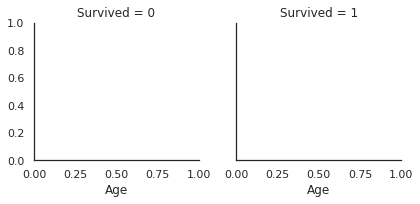

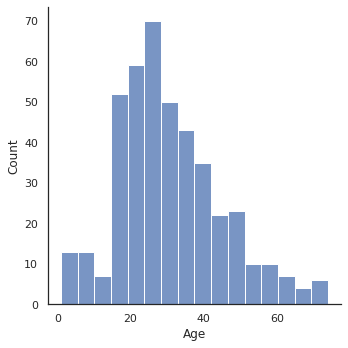

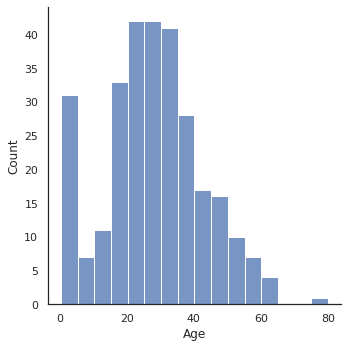

In [81]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.displot, 'Age')

나이분포는 꽤 꼬리가 긴 가우시안 분포를 보이는 듯 하다.
이러한 나이분포는 생존자 분포나 비생존자 분포와는 상이하다. 실제로 생존한 젊은 나이의 승객들 사이에서 피크가 한번 존재한다. 또한 60-80세에서 생존율이 떨어지는 것을 볼 수 있다.

비록 나이가 생존과 직접 상관이 없더라도 우리는 나이범주가 가능성이 있다는 것을 알 수 있다.

매우 젊은 승객은 생존가능성이 높은 것을 알 수 ㅣㅇㅆ다

<ipython-input-82-8ae11695e87b>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
<ipython-input-82-8ae11695e87b>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


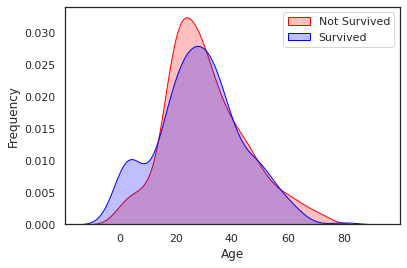

In [82]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두개의 밀도를 superimpose하면 우리는 명확하게 아기들과 매우 어린 어린이들과 상응하는 피크를 볼 수 있다

### Fare

In [83]:
dataset['Fare'].isnull().sum()

1

In [84]:
#Fill fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

하나의 결측치가 존재하나 큰 영향을 주지 않는것으로 확인되기 때문에 중간값으로 대체한다

<ipython-input-85-cbcf15e3a7d1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))


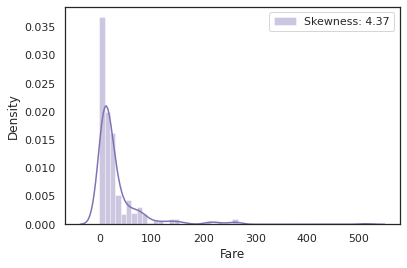

In [85]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

faren의 분포는 보시다싶이 매우 왜곡되었다. 이것은 scale되더라도 과적합의 문제로 이어질 수 있다.

이 경우 log변환을 통해 skew정도를 감소시키는 것이 바람직할 것 같다

In [86]:
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i>0 else 0)


<ipython-input-87-05ced9010dc8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))


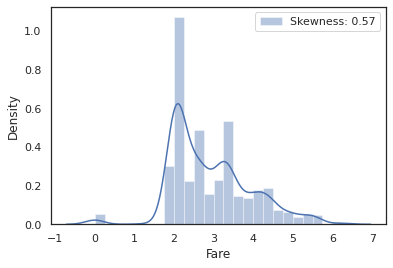

In [87]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g=g.legend(loc='best')

## 3.2 categorical values
### Sex

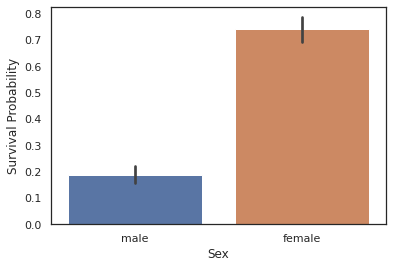

In [88]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [89]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


남성이 여성에 비해 생존 가능성이 낮아보이는 것이 명확하다

즉 성별은 생존예측에서 꽤 중요한 변수이다

타이타닉 영화에서는 여성과 어린이가 먼저! 라고 외쳤더라지....

### Pclass

In [ ]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6
                   palette='muted')
g.despine(left=True)
g=g.set_ylabels('survival probability')

In [ ]:
g=sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train,
                 size=6, kind='bar', palette='muted')
g.despine(left=True)
g=g.set_ylabels('survival probabiliy')

3 계층에서 완전히 동일하지 않다.

퍼스트가 타 계층에 비해 생존가능성이 높다

이 경향은 성별에서도 보인다

### Embarked

In [90]:
dataset['Embarked'].isnull().sum()

2

In [91]:
dataset['Embarked']=dataset['Embarked'].fillna('S')

2개의 결측치는 최빈값인 S로 채우기로 한다

In [ ]:
g = sns.factorplot(x="Embarked", y='Survived', data=train,
                   size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

cherboug로부터 온 승객들이 생존기회가 높아보인다

나의 가정은 같은 퍼스트더라도 퀸즈타운에서 온 사람보다 Cherbourg에서 온 사람이 더 생존기회가 많았다는 것이다

맞나 보자!

In [ ]:
g = sns.factorplot('Pclass',col='Embarked', data=train, size=6,
                   kind='count',palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

실제로 southampton n queensstown 출신의 3번쨰계층이가장 빈도수가 높은 반면 cherbourg 승객 중 대부분 첫번째 계층이 많았다. 하지만 첫번째계층은 생존율이 높았다.

이것을 보아하니 나는 왜 퍼스트가 높은 생존율을 보였는지 알 수 ㅓㅂㅅ다. 나으 ㅣ가정은 퍼스트가 그들의 영향력으로 인해 구조에서 우선시되었다는 것이다.

# 4. 걸측치 채우기
##4.1 Age
우리가 보다싶이 나이컬럼은 256의 결측치가 존재했다.

생존기회가 더 많았던 subpopulation이 존재하기 때문에 성별칼럼은 남겨두는 것이 좋을 것 같다.

이러한 문제를 다루기 위해 나이와 가장 상관관계가 많은 타 변수를 확인하였다.

In [ ]:
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass',data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

연령분포는 성별에서 큰 차이가 없어보이므로 나이를 예측하는데 있어서 성별은 유의미하지 않다.

하지만 계층의 경우 퍼스트에서 대체로 많이고령을, 2번째, 3번째에서 넘어갈수록 어려지는 경향을 보인다.

게다가 자녀나 부모가 더 많은 승객일수록 더 나이가 많고 사촌이나 배우자가 있을수록 더 어린 경향을 보였다

In [92]:
dataset['Sex']=dataset['Sex'].map({'male':0, 'female':1})


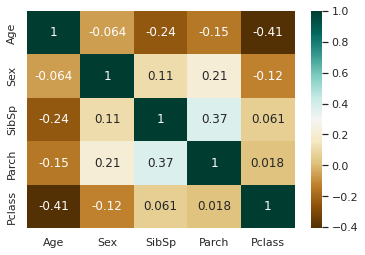

In [93]:
g = sns.heatmap(dataset[['Age', 'Sex','SibSp','Parch','Pclass']].corr(),cmap='BrBG',annot=True)

correlation map은 parch를 제외한 factorplot 관찰을 확인한다. 나이는 성별과 관련없으나 pclass, parch, sibsp과 부정의 상관관계를 보인다.

parch와의 나이 상관관계 플랏에서 나이는 부모, 어린이 수와 함께 자라나 대체로 부정의 상관관계를 보인다

그래서 sibsp, parch, pcalss를 이용하여 나이결측치를 사용하기로 한다

중간값이나 그 언저리으 ㅣ값을 채우는 전략과 이 전략은 유사하다.

In [94]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & dataset['Pclass']==dataset.iloc[i]['Pclass'])].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i]=age_pred
  else:
    dataset['Age'].iloc[i]=age_med

<ipython-input-94-493336c88cb8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i]=age_med
<ipython-input-94-493336c88cb8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i]=age_med
<ipython-input-94-493336c88cb8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i]=age_med
<ipython-input-94-493336c88cb8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [ ]:
g = sns.factorplot(x='Survived', y='Age',data=train,kind='box')
g=sns.factor(x='Survived',y='Age', data=train, kind='violin')

생존자와 비생존자의 연령사이의 중간값 차이가 없어보인다.

하지만 바이올린 플랏에서는 여전히 젊은 나이가 생존율이 높은 것을 알 수 있다.

#5.Feature Engineering
##5.1 Name/Title



In [95]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

naem은 승객의 제목정보를 포함한다.

어떤 특별한 타이틀을 가진 승객은 구조작업에서 우선시되었을 것이기 때문에 이것을 모델에 추가하는 것은 흥미롭다


In [96]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title']=pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

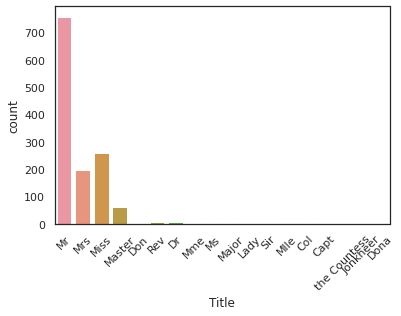

In [97]:
g = sns.countplot(x='Title', data=dataset)
g=plt.setp(g.get_xticklabels(), rotation=45)

17개의 제목이 존재하며 대부분 드물고 우리는 이를 4개의 그룹으로 나눌 수 있다

In [98]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

ValueError: ignored

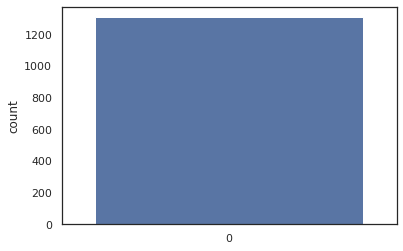

In [99]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

In [ ]:
g=sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g=g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('survival probability')

여성과 어린아이 먼저!
라면서 여성과 어린아이들이 생존기회가 더 적었다.

In [100]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

##5.2 FAMILY SIZE
우리는 대형 가족이 구조에 어려울 것이라 생각하는데, 이는 이들의 형제자매부모를 구조동안찾기 어려울 것이기 때문이다. 그래서 우리는 Fize(family size)라는 변수를 만들기로 했다.

In [101]:
dataset['Fsize']= dataset['SibSp']+dataset['Parch']+1


In [ ]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset)
g=g.set_ylabels('Survival Probability')

가족 사이즈는 꽤 중요한데 생존확률이 대형가족에서 더 낮기 때문이다.

추가적으로 네개의 범주를 추가시켰다.

In [102]:
dataset['Single']=dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF']=dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF']=dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF']=dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

In [103]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability)')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability)')
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability)')
g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability)')

AttributeError: ignored

가족 크기에 대한 factorplot은 작은 중간가족이 훨씬 생존 가능성이 큰 것을 확인시켰다.

In [104]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset= pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [105]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


##5.3 cabin

In [106]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [107]:
dataset['Cabin'].describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [108]:
dataset['Cabin'].isnull().sum()

1014

캐빈 피처는 292의 value와 1007개의 결측치를 가지는데 캐빈번호가 없는 사람들은 캐빈이 없었을 것으로 보인다

In [109]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [110]:
dataset['Cabin']=pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

첫글자는 데스크를 암시하는데 나는 이것을 정보로 남겨둘 것이다

In [112]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

ValueError: ignored

In [ ]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset,kind='bar',
                   order = ['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival probability')

캐빈을 가진 승객의 숫자는 낮기 때문에 생존확률이 중요한 표준편차를 가지며, 우리는 그들사이의 생존확률을 구벌하기 어렵다.

하지만 우리는 캐빈을 가진ㅅ ㅏ람이 대체로 높은 생존확률을 보인다는 것을 알 수 잇다.

BCDEF의 캐빈에서 사실로 보인다.


In [114]:
dataset=pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

## 5.4 TIcket


In [115]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 prefix를 공유하는 캐빈티켓은 함께 있음을 의미한다. 이것은 실제 캐빈의 배치가 함께임으로 이어질 수 있다.

같은 prefixes에대한 티켓은 유사한 클래스와 유사한 생존을 보인다.

그래서 티켓피처를 티켓의 prefix피쳐로 대체하는 것이 훨씬 informative할 것 같다.

In [116]:
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.',' ').replace('/',' ').strip().split(' ')[0])
  else:
    Ticket.append('X')
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0       A
1      PC
2    STON
3       X
4       X
Name: Ticket, dtype: object

In [117]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')


In [118]:
dataset['Pclass']=dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'],prefix='Pc')

In [119]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [120]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_SO,T_SOTON,T_STON,T_SW,T_W,T_WE,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


#6.Modeling*

In [122]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

<ipython-input-122-ba0274456a78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=['Survived'], axis=1, inplace=True)


In [125]:
train['Survived']=train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels =['Survived'], axis=1)

<ipython-input-125-4b2c303b23a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived']=train['Survived'].astype(int)


## 6.1 Simple modeling
### 6.1.1 Cross validate models
stratified k fold절차를 이용하여 10개의 대중적인 분류기를 비교하고 평가한다. 



SVC
Decision Tree
AdaBoost
Random Forest
Extra Trees
Gradient Boosting
Multiple layer perceprton (neural network)
KNN
Logistic regression
Linear Discriminant Analysis




In [126]:
kfold = StratifiedKFold(n_splits=10)

In [130]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))

  cv_means = []
  cv_std = []
  for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})


In [133]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

TypeError: ignored

SVC, ADABOOST, 랜포, 엑스트라트리 그리고 그레디언트분류기를 앙상블모델을 위해 선택하기로 했다!

### 6.1.2 Hyperparameter tunning for best models

결정한 애들에 대해 그리드 서치 옵션화를 진행하고자 한다.

nPjobs는 내가 cpu가 4개이므로 4개로 하면서 시간이 감소될 것이다.

하지만 이것은 엄청 오래걸린다. 난 15

In [136]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC,random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
            
gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [137]:
gsadaDTC.best_score_

0.8125717852684146

In [138]:
# ExtraTreeclassifier
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8328214731585518

In [140]:
# R F C
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8361797752808988

In [143]:
# GBC
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC =GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring='accuracy', verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  war

0.83167290886392

In [144]:
#SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.835043695380774

### 6.1.3 plot learning curves

학습곡선은 과대적합영향을 보기 좋아!

In [147]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes= np.linspace(.1, 1.0,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Trianing examples')
  plt.ylabel('Score')
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X,y,cv=cv, n_jobs=n_jobs, train_sizes = train_sizes
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean +train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   test_scores_mean +test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
  plt.legend(loc='best')
  return plt

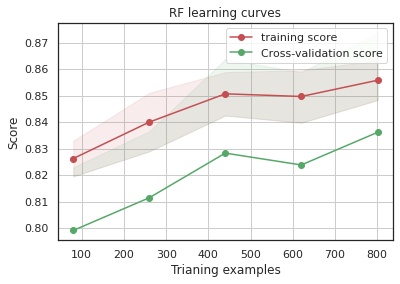

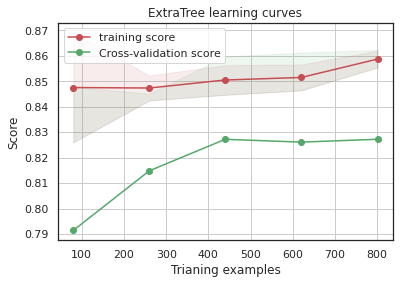

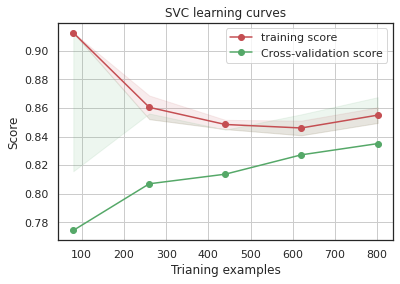

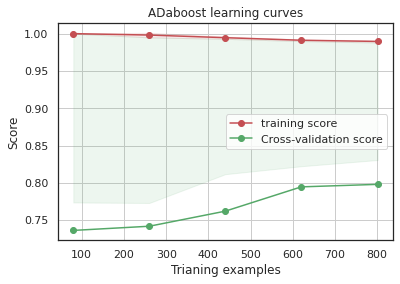

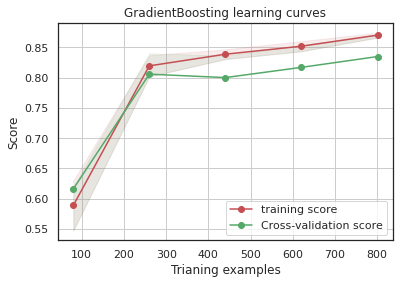

In [148]:
g = plot_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTree learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'ADaboost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)


Gradient boosting과 ada부스트 분류기는 훈련데이터를 과대적합하는 경향이 있다. 교차검증 커브가 커지는 것에 다르면 그레디언트부스트와 에이다 부스트는 훈련세트가 커질수록 더 잘 수행할 수 있다.

SVCC, EXTratrees 분류기는 훈련 데이터와 교차검증 커브가 가까운것을 통해 예측을 일반화하는데 유용할 것으로 보인다

###6.1.4  트리기반분류기의 피처 중요도
승객생존예측에 대해 유용한 피처를 보기 위해, 피처중요도를 4개의 트리기반에대해 표현해보았다.

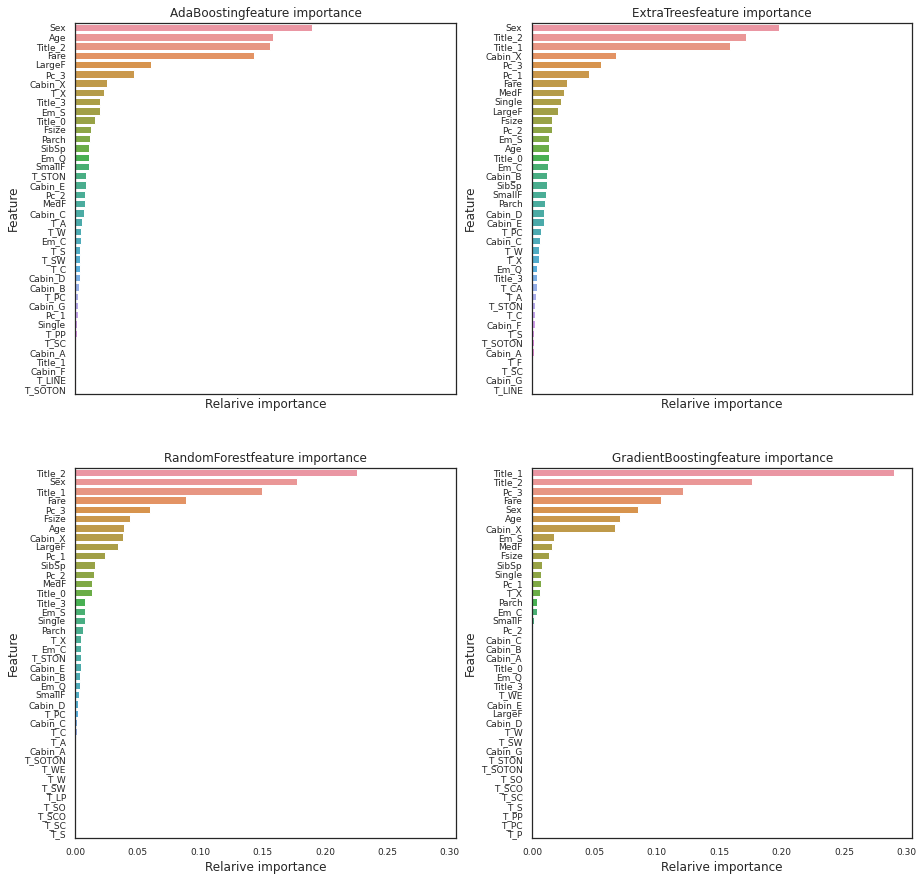

In [151]:
nrows = 2
ncols= 2
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, sharex='all', figsize = (15, 15))
names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]
nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g=sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40], orient='h',ax=axes[row][col])
    g.set_xlabel('Relarive importance', fontsize=12)
    g.set_ylabel('Feature', fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + 'feature importance')
    nclassifier +=1

4개의 분류기가 각자 가장 중요하게 생각하는 피처가 다르다는 것을 주목해야 한다. 이것은 그들의 예측이 같은 피처기반으로 이루어지지 않았다는 것을 ㅡ이미한다. 그럼에도 불구하고 그들은 분류에 대해 공통의 중요한 피처를 가진 것으로 보인다.

Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.

Age and Title_1 (Master) refer to the age of passengers.

Fsize, LargeF, MedF, Single refer to the size of the passenger family.

피처중요도에 따르면 생존예측은 오히려 보트에서의 위치보단 나이와 성별,가족크기 그리고 사회적 지위와 굉장한 연관이 있는 것으로 보인다.

In [153]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC ')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

In [ ]:
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC,test_Survived_SVMC], axis=1)
g = sns.heatmap(ensemble_results.corr(), annot=True)

ada가 다른 분류기와 비교되었 때를 제외하곤 꽤 다들 비슷해보인다.

다섯개의 분류기는 좀 더 혹은 덜 같은 예측을 보이나 차이는 분명 존재한다. 이러한 차이는 앙상블모델에서 투표로 고려하기 충분하다.

##6.2 Ensemble modeling
### 6.2.1 Combinig models
소프트 voting 분류기로 통합하고자 한다

In [154]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best),('extc', ExtC_best),('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=-1)
votingC = votingC.fit(X_train, Y_train)

##6.3 prediction
### 6.3.1 predict and submit results



In [155]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensembel_python_voting.csv', index=False)